In [188]:
import numpy as np
import pandas as pd 

In [189]:
data = pd.read_csv('data/mnist_with_anomalies.csv')
data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
matrix = data.to_numpy()
matrix.shape

(6963, 784)

In [191]:
matrix


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(6963, 784))

In [192]:
first = matrix[3093]
first = first.reshape(28,28)

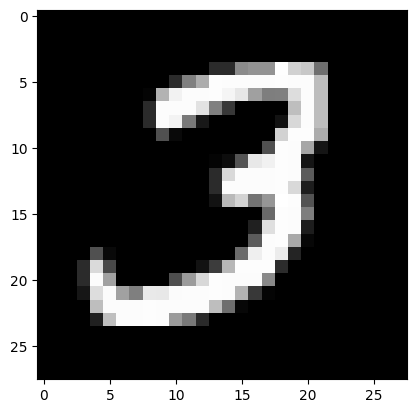

In [193]:
import matplotlib.pyplot as plt

plt.imshow(first, cmap='gray')

In [196]:
anomalies_indices = np.array([81, 143, 223, 329, 352, 401, 663, 701, 712, 790, 863, 2597, 2609, 2658, 2704, 2726, 2781, 3093, 3203, 3295, 6065, 6229, 6235, 6535, 6857])
anomalies_matrix = matrix[anomalies_indices]
def percentage_of_finded_anomalities(found_anomalities, total_anomalities):
    num_of_anomalities = len(total_anomalities)
    count = 0
    for index in found_anomalities:
        if index in total_anomalities:
            count += 1
    return count / num_of_anomalities * 100

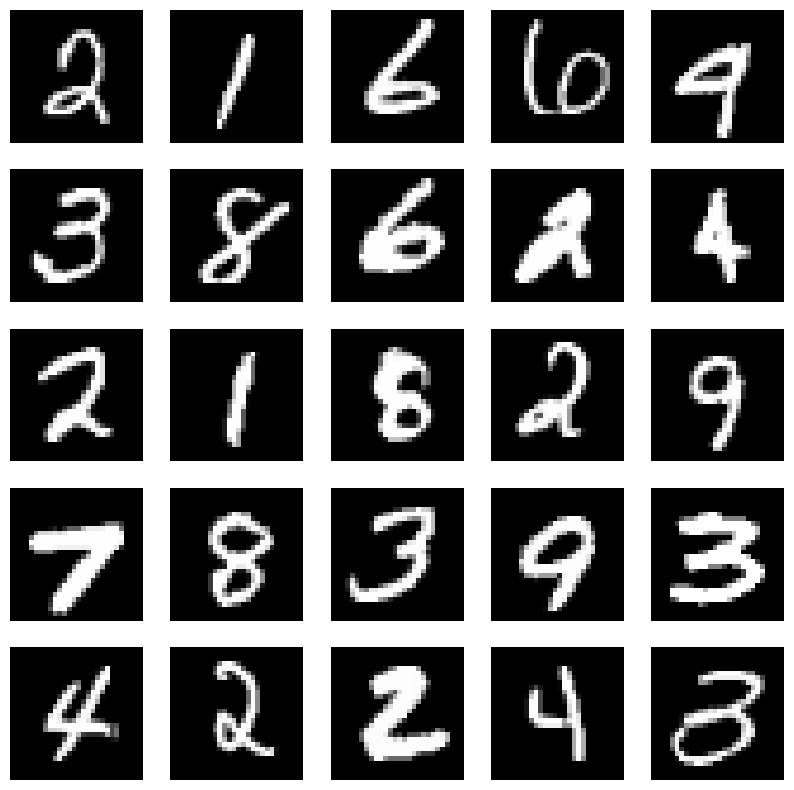

In [198]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 grid
for i, ax in enumerate(axes.flat):
    ax.imshow(anomalies_matrix[i].reshape(28, 28), cmap='gray')
    ax.axis('off')  # Hide axis
plt.show()

In [246]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.80)

In [247]:
matrix_pca = pca.fit_transform(matrix)



In [248]:
matrix_reconstructed = pca.inverse_transform(matrix_pca)

In [249]:
reconstruction_error = np.mean((matrix - matrix_reconstructed) ** 2, axis=1)

In [253]:
threshold = np.percentile(reconstruction_error, 98)

In [254]:
anomalies = np.where(reconstruction_error > threshold)[0]

In [255]:
print("Anomalies detected at indices:", anomalies)


Anomalies detected at indices: [  17   81  223  322  329  352  403  435  663  701  712  736  741  781
  785  790  837  859  863  945  953 1018 1047 1090 1328 1369 1378 1384
 1421 1472 1479 1501 1679 1721 1759 1773 1840 1928 1954 2054 2057 2095
 2175 2218 2225 2465 2481 2528 2551 2562 2578 2597 2609 2621 2624 2658
 2700 2704 2726 2765 2781 2829 2869 3102 3119 3123 3203 3216 3219 3265
 3275 3295 3353 3377 3438 3532 3602 3622 3707 3773 3783 3850 4006 4055
 4058 4082 4134 4166 4195 4205 4237 4250 4322 4327 4387 4389 4445 4460
 4626 4629 4667 4670 4788 4831 4835 4933 4948 4949 4952 5126 5151 5216
 5264 5278 5367 5425 5647 5707 5942 5985 6038 6046 6065 6081 6130 6229
 6260 6280 6328 6351 6454 6535 6568 6590 6635 6657 6704 6708 6784 6857]


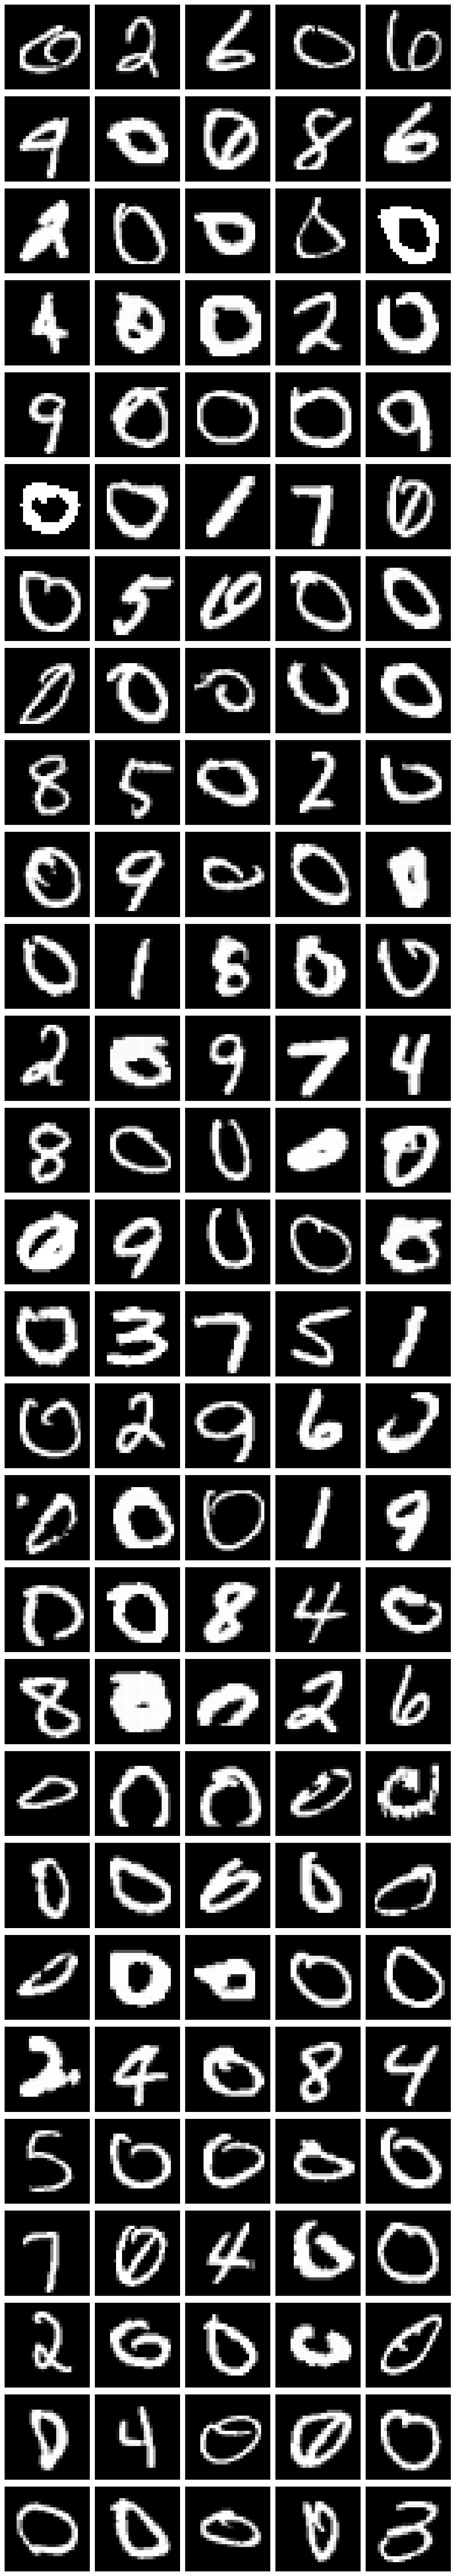

In [256]:
pca_anomaly_matrix = matrix[anomalies].reshape(-1, 28, 28)
num_anomalies = len(pca_anomaly_matrix)
cols = 5
rows = int(np.ceil(num_anomalies / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(pca_anomaly_matrix[i], cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [257]:
percentage_of_finded_anomalities(anomalies, anomalies_indices)

84.0